In [1]:
!pip install torch --index-url https://download.pytorch.org/whl/cu121
!pip install triton
!pip install "causal-conv1d>=1.4.0"
!pip install --no-build-isolation mamba-ssm==2.2.4
!pip install torch torchvision

Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.3 MB/s et

In [2]:

import os
import csv
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# -------------------------
# Device + reproducibility
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
# # Keep deterministic if you used it before (comment/uncomment as desired)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


Using device: cuda


Detected pairs: 3929

--- Training Mamba-UNet-bottleneck-only ---
Epoch 1/50 | Model: Mamba-UNet-bottleneck-only | Train Loss: 1.1036 | Val Loss: 0.9316 | Val Dice: 0.1376 | Val IoU: 0.0771 | Epoch Time: 77.8s
Epoch 2/50 | Model: Mamba-UNet-bottleneck-only | Train Loss: 0.8382 | Val Loss: 0.8724 | Val Dice: 0.2156 | Val IoU: 0.1311 | Epoch Time: 89.7s
Epoch 3/50 | Model: Mamba-UNet-bottleneck-only | Train Loss: 0.6256 | Val Loss: 0.5566 | Val Dice: 0.4746 | Val IoU: 0.3453 | Epoch Time: 92.9s
Epoch 4/50 | Model: Mamba-UNet-bottleneck-only | Train Loss: 0.5193 | Val Loss: 0.5237 | Val Dice: 0.5061 | Val IoU: 0.3751 | Epoch Time: 93.2s
Epoch 5/50 | Model: Mamba-UNet-bottleneck-only | Train Loss: 0.4625 | Val Loss: 0.4543 | Val Dice: 0.5721 | Val IoU: 0.4432 | Epoch Time: 93.8s
Epoch 6/50 | Model: Mamba-UNet-bottleneck-only | Train Loss: 0.3942 | Val Loss: 0.4896 | Val Dice: 0.5366 | Val IoU: 0.4193 | Epoch Time: 94.0s
Epoch 7/50 | Model: Mamba-UNet-bottleneck-only | Train Loss: 0.3684 | 

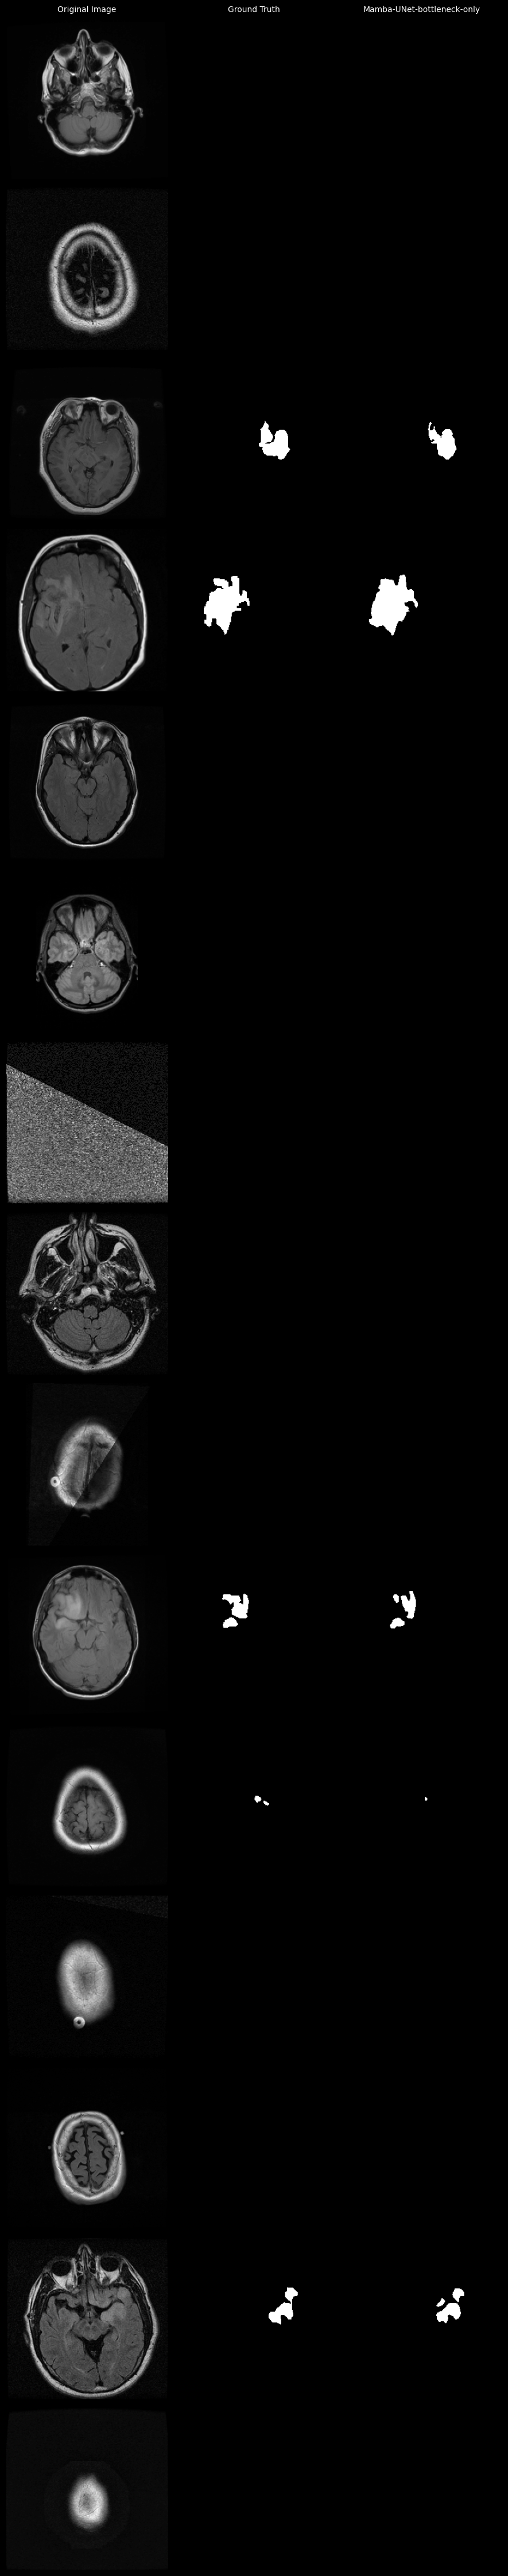

In [3]:

# -------------------------
# Dataset utilities
# -------------------------
def find_lgg_pairs(root: str):
    root = Path(root)
    pairs = []
    for f in root.rglob("*.tif"):
        if f.stem.endswith("_mask"):
            continue
        mask_path = f.with_name(f.stem + "_mask.tif")
        if mask_path.exists():
            pairs.append((str(f), str(mask_path)))
    return pairs

class LGGSegmentationDataset(Dataset):
    def __init__(self, pairs, img_size=256):
        self.pairs = pairs
        self.img_size = img_size

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_p, mask_p = self.pairs[idx]
        img = Image.open(img_p).convert('L')
        mask = Image.open(mask_p).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.BILINEAR)
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)
        img = np.array(img, dtype=np.float32)[None, ...]
        img = (img - img.mean()) / (img.std() + 1e-8)
        mask = (np.array(mask) > 127).astype(np.uint8)[None, ...]
        
        return torch.from_numpy(img), torch.from_numpy(mask).float()

# -------------------------
# Metrics, losses, helpers
# -------------------------
def dice_coeff(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    union = preds_flat.sum() + targets_flat.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou_coeff(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    union = preds_flat.sum() + targets_flat.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1e-6):
        inputs_sigmoided = torch.sigmoid(inputs)
        inputs_flat = inputs_sigmoided.view(-1)
        targets_flat = targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        bce = self.bce_loss(inputs, targets)
        dice_bce = bce + dice_loss
        return dice_bce

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_time(model, test_input, device, num_warmups=10, num_runs=100):
    model.eval()
    test_input = test_input.to(device).float()
    with torch.no_grad():
        for _ in range(num_warmups):
            _ = model(test_input)
    if device == "cuda":
        torch.cuda.synchronize()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(test_input)
    if device == "cuda":
        torch.cuda.synchronize()
    end_time = time.time()
    avg_time_ms = ((end_time - start_time) / num_runs) * 1000
    return avg_time_ms

def visualize_predictions(models, val_dataset, device, num_samples=15, output_fname="predictions_first10.png"):
    plt.style.use('dark_background')

    num_samples = min(num_samples, len(val_dataset))
    if num_samples == 0:
        print("No images in validation dataset to visualize.")
        return

    model_names = list(models.keys())
    ncols = 2 + len(model_names)  # Original, GT, and one column per model

    fig, axes = plt.subplots(num_samples, ncols, figsize=(3 * ncols, 3 * num_samples))

    if num_samples == 1:
        axes = axes[np.newaxis, :]

    axes[0, 0].set_title("Original Image", fontsize=10)
    axes[0, 1].set_title("Ground Truth", fontsize=10)
    for j, name in enumerate(model_names):
        axes[0, j + 2].set_title(name, fontsize=10)

    indices = list(range(num_samples))

    for i, idx in enumerate(indices):
        image, mask = val_dataset[idx]
        image, mask = image.to(device), mask.to(device)

        image_vis = image.cpu().squeeze().numpy()
        mask_vis = mask.cpu().squeeze().numpy()

        row_axes = axes[i]

        row_axes[0].imshow(image_vis, cmap='gray')
        row_axes[0].axis('off')
        row_axes[1].imshow(mask_vis, cmap='gray')
        row_axes[1].axis('off')

        for j, (name, model) in enumerate(models.items()):
            model.eval()
            with torch.no_grad():
                output = model(image.unsqueeze(0))
                predicted_mask = (torch.sigmoid(output) > 0.5).float().cpu().squeeze().numpy()
            row_axes[j + 2].imshow(predicted_mask, cmap='gray')
            row_axes[j + 2].axis('off')

    plt.tight_layout()
    plt.savefig(output_fname, dpi=300)
    print(f"\nVisualizations saved to {output_fname}")

def print_comparison_table(results):
    print("\n" + "="*120)
    print("Final Model Comparison")
    print("="*120)
    headers = ["Model", "Parameters (M)", "Inference Time (ms)", "Total Time (s)", "Avg. Time/Epoch (s)", "Best Val Dice", "Best Val IoU"]
    print(f"{headers[0]:<30} {headers[1]:<20} {headers[2]:<20} {headers[3]:<20} {headers[4]:<20} {headers[5]:<20} {headers[6]:<20}")
    print("-"*120)
    for result in results:
        best_dice_index = np.argmax(result['history']['val_dice']) if len(result['history']['val_dice']) > 0 else 0
        best_dice_score = result['history']['val_dice'][best_dice_index] if len(result['history']['val_dice']) > 0 else 0.0
        best_iou_score = result['history']['val_iou'][best_dice_index] if len(result['history']['val_iou']) > 0 else 0.0
        
        print(f"{result['model']:<30} {result['params_M']:.2f}{'':<16} {result['inference_time']:.2f}{'':<16} {result['total_time']:.2f}{'':<16} {result['avg_time_per_epoch']:.2f}{'':<16} {best_dice_score:.4f}{'':<12} {best_iou_score:.4f}")
    print("="*120)

# -------------------------
# Model definitions (base_ch = 32)
# -------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# Set base channels to 32 (was 64 originally)
BASE_CH = 32

class UNetSmall(nn.Module):
    """Standard U-Net but with base channels = 32."""
    def __init__(self, in_channels=1, out_channels=1, base_ch=BASE_CH):
        super().__init__()
        # Encoder
        self.conv1 = ConvBlock(in_channels, base_ch)          # 32
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = ConvBlock(base_ch, base_ch*2)            # 64
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = ConvBlock(base_ch*2, base_ch*4)          # 128
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = ConvBlock(base_ch*4, base_ch*8)          # 256
        self.pool4 = nn.MaxPool2d(2)
        # Bottleneck
        self.conv_bottleneck = ConvBlock(base_ch*8, base_ch*16)  # 512
        # Decoder
        self.up4 = nn.ConvTranspose2d(base_ch*16, base_ch*8, 2, 2)
        self.conv5 = ConvBlock(base_ch*16, base_ch*8)
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 2, 2)
        self.conv6 = ConvBlock(base_ch*8, base_ch*4)
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, 2)
        self.conv7 = ConvBlock(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, 2)
        self.conv8 = ConvBlock(base_ch*2, base_ch)
        self.conv_out = nn.Conv2d(base_ch, out_channels, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        cb = self.conv_bottleneck(p4)
        u4 = self.up4(cb)
        u4 = torch.cat([u4, c4], dim=1)
        c5 = self.conv5(u4)
        u3 = self.up3(c5)
        u3 = torch.cat([u3, c3], dim=1)
        c6 = self.conv6(u3)
        u2 = self.up2(c6)
        u2 = torch.cat([u2, c2], dim=1)
        c7 = self.conv7(u2)
        u1 = self.up1(c7)
        u1 = torch.cat([u1, c1], dim=1)
        c8 = self.conv8(u1)
        output = self.conv_out(c8)
        return output

# Mamba bottleneck only block (safe fallback if mamba_ssm not installed)
class MambaBottleneckBlock(nn.Module):
    def __init__(self, in_c, d_model=None, d_state=16, d_conv=4, expand=2):
        super().__init__()
        d_model = d_model if d_model is not None else in_c
        self.proj = nn.Linear(in_c, d_model)
        try:
            # prefer using the real Mamba if available
            from mamba_ssm import Mamba
            self.mamba = Mamba(d_model, d_state, d_conv, expand)
            self._has_mamba = True
        except Exception:
            # fallback lightweight MLP-like block so script runs without mamba_ssm
            self._has_mamba = False
            self.mamba = nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.ReLU(inplace=True),
                nn.Linear(d_model, d_model),
            )
        self.norm = nn.LayerNorm(d_model)
        self.proj_out = nn.Linear(d_model, in_c)

    def forward(self, x):
        b, c, h, w = x.shape
        x_flat = x.permute(0, 2, 3, 1).view(b, h*w, c)
        x_m = self.norm(self.proj(x_flat))
        x_m = self.mamba(x_m)
        x_m = self.proj_out(x_m)
        x_out = x_m.view(b, h, w, c).permute(0, 3, 1, 2)
        return x_out + x

class MambaUNet_BottleneckOnly(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_ch=BASE_CH):
        super().__init__()
        # Encoder (no Mamba blocks here)
        self.conv1 = ConvBlock(in_channels, base_ch)          # 32
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = ConvBlock(base_ch, base_ch*2)            # 64
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = ConvBlock(base_ch*2, base_ch*4)          # 128
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = ConvBlock(base_ch*4, base_ch*8)          # 256
        self.pool4 = nn.MaxPool2d(2)
        # Bottleneck conv then Mamba bottleneck
        self.conv_bottleneck = ConvBlock(base_ch*8, base_ch*16)  # 512
        self.mamba_bottleneck = MambaBottleneckBlock(base_ch*16, d_model=base_ch*16)
        # Decoder
        self.up4 = nn.ConvTranspose2d(base_ch*16, base_ch*8, 2, 2)
        self.conv5 = ConvBlock(base_ch*16, base_ch*8)
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, 2, 2)
        self.conv6 = ConvBlock(base_ch*8, base_ch*4)
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 2, 2)
        self.conv7 = ConvBlock(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 2, 2)
        self.conv8 = ConvBlock(base_ch*2, base_ch)
        self.conv_out = nn.Conv2d(base_ch, out_channels, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        cb = self.conv_bottleneck(p4)
        cb = self.mamba_bottleneck(cb)
        u4 = self.up4(cb)
        u4 = torch.cat([u4, c4], dim=1)
        c5 = self.conv5(u4)
        u3 = self.up3(c5)
        u3 = torch.cat([u3, c3], dim=1)
        c6 = self.conv6(u3)
        u2 = self.up2(c6)
        u2 = torch.cat([u2, c2], dim=1)
        c7 = self.conv7(u2)
        u1 = self.up1(c7)
        u1 = torch.cat([u1, c1], dim=1)
        c8 = self.conv8(u1)
        output = self.conv_out(c8)
        return output

# -------------------------
# Training & evaluation loop
# -------------------------
def train_and_validate_model(model_name, model, train_loader, val_loader, epochs, device):
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
    loss_fn = DiceBCELoss()
    model.to(device)
    
    history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device).float(), masks.to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device).float(), masks.to(device).float()
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()
                
                dice = dice_coeff(outputs, masks)
                iou = iou_coeff(outputs, masks)
                val_dice += dice.item()
                val_iou += iou.item()
        
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        epoch_end = time.time()
        print(f"Epoch {epoch+1}/{epochs} | Model: {model_name} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f} | Epoch Time: {epoch_end - epoch_start:.1f}s")
            
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_epoch = total_time / epochs if epochs > 0 else 0
    
    best_dice_index = np.argmax(history['val_dice']) if len(history['val_dice'])>0 else 0
    
    best_epoch_metrics = {
        'best_val_dice': history['val_dice'][best_dice_index] if len(history['val_dice'])>0 else 0.0,
        'best_val_iou': history['val_iou'][best_dice_index] if len(history['val_iou'])>0 else 0.0,
        'avg_time_per_epoch': avg_time_per_epoch,
        'total_time': total_time
    }
            
    return history, best_epoch_metrics, count_params(model)

# -------------------------
# Main entry
# -------------------------
if __name__ == "__main__":
    DATA_ROOT = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"
    if not os.path.exists(DATA_ROOT):
        print(f"Dataset not found at {DATA_ROOT}. Please upload the dataset to this path.")
    else:
        pairs = find_lgg_pairs(DATA_ROOT)
        print("Detected pairs:", len(pairs))
        random.shuffle(pairs)
        split = int(0.8 * len(pairs))
        train_pairs, val_pairs = pairs[:split], pairs[split:]
        train_dataset, val_dataset = LGGSegmentationDataset(train_pairs), LGGSegmentationDataset(val_pairs)
        
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    
        models = {
            "Mamba-UNet-bottleneck-only": MambaUNet_BottleneckOnly(in_channels=1, out_channels=1, base_ch=BASE_CH),
        }
    
        results = []

        for name, model in models.items():
            print(f"\n--- Training {name} ---")
            
            model.to(DEVICE)

            param_count = count_params(model)
            # create a test input tensor for timing (shape matches training size)
            test_input = torch.randn(1, 1, 256, 256).to(DEVICE).float()
            inference_time = measure_inference_time(model, test_input, DEVICE)
            # Train for 25 epochs (between 20-30 as requested)
            epochs = 50
            history, best_metrics, _ = train_and_validate_model(name, model, train_loader, val_loader, epochs, DEVICE)
            
            results.append({
                "model": name,
                "params_M": param_count / 1e6,
                "inference_time": inference_time,
                "total_time": best_metrics['total_time'],
                "avg_time_per_epoch": best_metrics['avg_time_per_epoch'],
                "best_val_dice": best_metrics['best_val_dice'],
                "best_val_iou": best_metrics['best_val_iou'],
                "history": history
            })
    
        csv_file = "results.csv"
        with open(csv_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["model", "epoch", "train_loss", "val_loss", "val_dice", "val_iou"])
            for result in results:
                for i in range(len(result['history']['val_dice'])):
                    writer.writerow([
                        result['model'],
                        i + 1,
                        result['history']['train_loss'][i],
                        result['history']['val_loss'][i],
                        result['history']['val_dice'][i],
                        result['history']['val_iou'][i]
                    ])
        print(f"\nResults saved to {csv_file}")
        
        # Visualize predictions for the FIRST 15 images (or fewer if val set < 15)
        visualize_predictions(models, val_dataset, DEVICE, num_samples=15, output_fname="predictions_first10.png")
        print_comparison_table(results)
